In [1]:
!git clone https://github.com/Ro6ertWcislo/AutoESN.git

Cloning into 'AutoESN'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 598 (delta 14), reused 6 (delta 6), pack-reused 564
Receiving objects: 100% (598/598), 433.19 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from matplotlib import pyplot as plt
import numpy as np
import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import MackeyGlass
from auto_esn.esn.esn import GroupedDeepESN
from auto_esn.esn.reservoir.activation import self_normalizing_default
from auto_esn.esn.reservoir.util import NRMSELoss
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.util import NRMSELoss


nrmse = NRMSELoss()

four datasets - electricity, temperatur, [hungarian chickenpox](https://archive.ics.uci.edu/dataset/580/hungarian+chickenpox+cases), my own data



In [ ]:
!unzip chick.zip

### Hungarian chickenpox dataset

In [11]:
data = pd.read_csv('hungary_chickenpox.csv')
data.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [12]:
data_min_max_scaled = data.copy().drop(columns = ['Date'])

# apply normalization techniques
for column in data_min_max_scaled.columns:
    data_min_max_scaled[column] = (data_min_max_scaled[column] - data_min_max_scaled[column].min()) / (data_min_max_scaled[column].max() - data_min_max_scaled[column].min())

# view normalized data
data = data_min_max_scaled

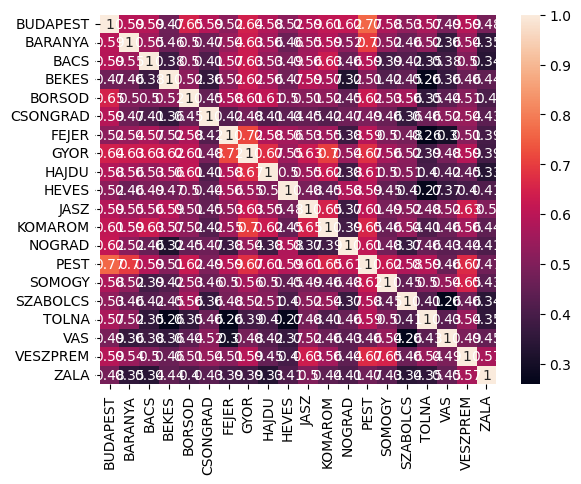

In [13]:
sn.heatmap(data.corr(), annot=True)
plt.show()

### Data preparation

In [14]:
def make_x_y(data, x_cols, y_cols):
    return data[x_cols], data[y_cols]

def split_many_to_many(data_x, data_y, past_steps = 1, future_steps = 1):
    X = []
    y = []
    for i in range(past_steps, len(data_x) - future_steps):
        X.append(data_x.loc[i-past_steps+1:i,:])
        y.append(data_y.loc[i+1:i+future_steps,:])

    return X, y

def make_train_test_split(x,y, p = 0.75):
    train_X, train_y = x[:int((1-p)*len(x))], y[:int((1-p)*len(y))]
    test_X, test_y = x[int((1-p)*len(x)):], y[int((1-p)*len(y)):]
    return train_X, train_y, test_X, test_y

def data_to_torch(data):
    a = np.array(data)
    return torch.from_numpy(a)

In [15]:
def prepare_dataset(data, columns_x, columns_y, past_steps, future_steps):
    data_x, data_y = make_x_y(data, columns_x, columns_y)
    splitted_x, splitted_y = split_many_to_many(data_x, data_y, past_steps = past_steps, future_steps = future_steps)
    train_X, train_y, test_X, test_y = make_train_test_split(splitted_x, splitted_y)
    train_X, train_y, test_X, test_y = data_to_torch(train_X), data_to_torch(train_y), data_to_torch(test_X), data_to_torch(test_y)

    return train_X, train_y, test_X, test_y

In [16]:
data.columns

Index(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'],
      dtype='object')

In [17]:
train_X, train_y, test_X, test_y = prepare_dataset(data, ['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
       'FEJER', 'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST',
       'SOMOGY', 'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'], ['BUDAPEST'], 1,1)

In [18]:
train_X.shape, train_y.shape

(torch.Size([130, 1, 20]), torch.Size([130, 1, 1]))

### esn definition

In [19]:
def best_deepesn_initializer(seed):
    # initialize input weights with uniform distribution from -1 to 1 and specified seed to reproduce results
    input_weight = CompositeInitializer().with_seed(seed).uniform()

    reservoir_weight = CompositeInitializer() \
        .with_seed(seed) \
        .uniform() \
        .sparse(density=0.1) \
        .spectral_normalize() \
        .scale(factor=1.0)  # unnecesary but i wanted to make it explicit

    return WeightInitializer(weight_ih_init=input_weight, weight_hh_init=reservoir_weight)

In [20]:
X, X_test, y, y_test = train_X, test_X, train_y, test_y

X = torch.reshape(X, (X.shape[0],20))
y = torch.reshape(y, (y.shape[0],1))

X_test = torch.reshape(X_test, (X_test.shape[0],20))
y_test = torch.reshape(y_test, (y_test.shape[0],1))

activation = self_normalizing_default(leaky_rate=1, spectral_radius=120)
seed = 70

In [21]:
def get_activation(leaky_rate = 1, radius = 500):
    return self_normalizing_default(leaky_rate=leaky_rate, spectral_radius=radius)

In [22]:
def get_esn(activation, input_size = 6, groups = 4, groups_def = (2,5,6,3), hidden_size =300, seed = 70):
    esn = GroupedDeepESN(
        input_size=input_size,
        groups=groups,
        num_layers=groups_def,
        hidden_size=hidden_size,
        initializer=best_deepesn_initializer(seed),
        activation=activation
    )
    return esn

In [23]:
esn = get_esn(get_activation(), input_size = 20)

In [24]:
esn.fit(X, y)

### Optuna study

In [25]:
def objective(trial):
    activation = get_activation(
        leaky_rate = trial.suggest_float("leaky_rate", 0.85, 1.2),
        radius = trial.suggest_int("spectral radius", 50,800))
    esn = get_esn(activation, input_size = 20,hidden_size = trial.suggest_int("hidden_size",100,550))
    esn.fit(X, y)
    output = esn(X_test)
    return nrmse(output, y_test).item()

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

[I 2024-01-23 14:38:07,370] A new study created in memory with name: no-name-005a5a9d-2ef5-4121-8b30-f3dbe8c3e298
[I 2024-01-23 14:38:09,082] Trial 0 finished with value: 1.338965101876349 and parameters: {'leaky_rate': 0.9412697561505667, 'spectral radius': 630, 'hidden_size': 201}. Best is trial 0 with value: 1.338965101876349.
[I 2024-01-23 14:38:12,269] Trial 1 finished with value: 0.9986228218676452 and parameters: {'leaky_rate': 1.069232103467843, 'spectral radius': 594, 'hidden_size': 274}. Best is trial 1 with value: 0.9986228218676452.
[I 2024-01-23 14:38:14,105] Trial 2 finished with value: 1.0825524426249047 and parameters: {'leaky_rate': 0.8867566523380253, 'spectral radius': 388, 'hidden_size': 223}. Best is trial 1 with value: 0.9986228218676452.
[I 2024-01-23 14:38:17,326] Trial 3 finished with value: 0.9859885989746123 and parameters: {'leaky_rate': 1.120458964905429, 'spectral radius': 110, 'hidden_size': 355}. Best is trial 3 with value: 0.9859885989746123.
[I 2024-01

In [27]:
study.best_params

{'leaky_rate': 1.0891417229061164, 'spectral radius': 274, 'hidden_size': 109}

#visualize one step ahead prediction

value of nrmse metric:  0.8958995754606291


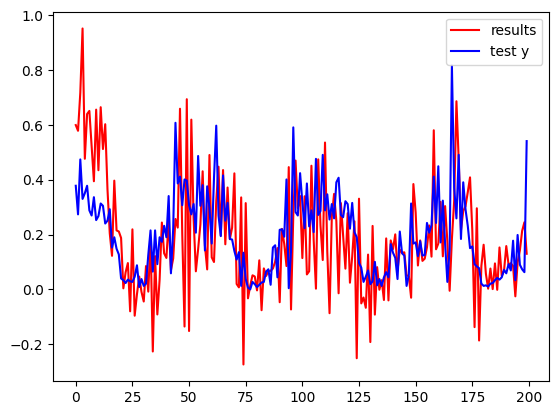

In [28]:
esn = get_esn(get_activation(leaky_rate = study.best_params['leaky_rate'],
                             radius = study.best_params['spectral radius']), input_size= 20,
              hidden_size = study.best_params['hidden_size'])
esn.fit(X, y)

output = esn(X_test)
# evaluate
n = nrmse(output, y_test).item()
print('value of nrmse metric: ',n)
# plot
last = 200
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r', label = 'results')
plt.plot(range(last), y_test.view(-1).detach().numpy()[-last:], 'b', label = 'test y')
leg = plt.legend(loc='upper right')
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

print('values for one step ahead prediction')
print('nrmse : ',n)
print('mse : ', mean_squared_error(output, y_test))
print('mape : ', mean_absolute_percentage_error(output, y_test))

values for one step ahead prediction
nrmse :  0.8958995754606291
mse :  0.036847257757117904
mape :  4.20458288233941


### Extrapolation multistep ahead prediction


In [30]:
steps = [8]
train_X, train_y, test_X, test_y = prepare_dataset(data, ['BEKES', 'ZALA', 'BUDAPEST'], ['BEKES', 'ZALA', 'BUDAPEST'], 1,1)

In [31]:
X, X_test, y, y_test = train_X, test_X, train_y, test_y

X = torch.reshape(X, (X.shape[0],3))
y = torch.reshape(y, (y.shape[0],3))

X_test = torch.reshape(X_test, (X_test.shape[0],3))
y_test = torch.reshape(y_test, (y_test.shape[0],3))

activation = self_normalizing_default(leaky_rate=1, spectral_radius=120)
seed = 70

In [32]:
def objective(trial):
    activation = get_activation(
        leaky_rate = trial.suggest_float("leaky_rate", 0.85, 1.2),
        radius = trial.suggest_int("spectral radius", 100,800))
    esn = get_esn(activation, input_size = 3,hidden_size = trial.suggest_int("hidden_size",100,550))
    esn.fit(X, y)
    output = esn(X_test)
    return nrmse(output, y_test).item()

In [33]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

[I 2024-01-23 14:55:05,551] A new study created in memory with name: no-name-fafd967d-adf5-4fd8-91fe-f1a68cb9160d
[I 2024-01-23 14:55:07,775] Trial 0 finished with value: 1.043619749234203 and parameters: {'leaky_rate': 0.8949159444617409, 'spectral radius': 315, 'hidden_size': 265}. Best is trial 0 with value: 1.043619749234203.
[I 2024-01-23 14:55:09,077] Trial 1 finished with value: 1.0800344194909863 and parameters: {'leaky_rate': 0.9288021408414937, 'spectral radius': 391, 'hidden_size': 161}. Best is trial 0 with value: 1.043619749234203.
[I 2024-01-23 14:55:14,227] Trial 2 finished with value: 1.0046275804636613 and parameters: {'leaky_rate': 1.0396404113835076, 'spectral radius': 772, 'hidden_size': 507}. Best is trial 2 with value: 1.0046275804636613.
[I 2024-01-23 14:55:20,678] Trial 3 finished with value: 0.9998480755178591 and parameters: {'leaky_rate': 1.1770567745479963, 'spectral radius': 748, 'hidden_size': 547}. Best is trial 3 with value: 0.9998480755178591.
[I 2024-0

In [34]:
esn = get_esn(get_activation(leaky_rate = study.best_params['leaky_rate'],
                             radius = study.best_params['spectral radius']),
              hidden_size = study.best_params['hidden_size'], input_size = 3)

In [35]:
esn.fit(X, y)

Extrapolation error: 1.1255918209538247


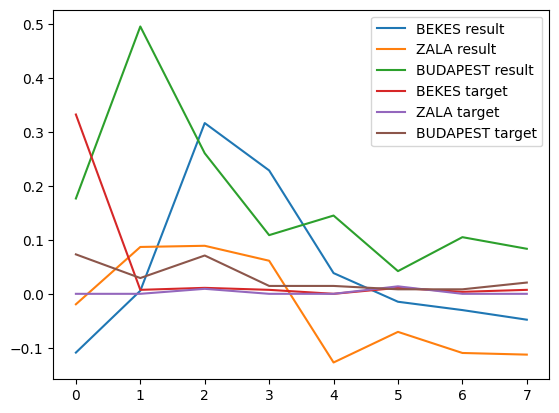

values for multi step ahead prediction
nrmse :  1.1255918209538247
mse :  0.02969749843710162
mape :  1.079056308488281


In [36]:
extrapolation_steps = steps[0]
val = X_test[0:1]
result = []
for j in range(extrapolation_steps):  # 100 steps ahead
    val = esn(val)  # (1,1) tensor
    result.append(val)

res = torch.vstack(result)
# evaluate
err = nrmse(res, y_test[:extrapolation_steps]).item()
print(f"Extrapolation error: {err}")

# plot validation set

# plot
last = 200
# we have 2dimensional input, so we have to plot two series for ground truth and for prediction
# plot original prediction
plt.plot(range(extrapolation_steps), res[:, 0].view(-1).detach().numpy()[-last:],  label = 'BEKES result')
# plot shifted prediction
plt.plot(range(extrapolation_steps), res[:, 1].view(-1).detach().numpy()[-last:],   label = 'ZALA result')
plt.plot(range(extrapolation_steps), res[:, 2].view(-1).detach().numpy()[-last:],   label = 'BUDAPEST result')
# plot original ground truth
plt.plot(range(extrapolation_steps), y_test[:extrapolation_steps, 0].view(-1).detach().numpy()[-last:],  label = 'BEKES target')
# plot shifted ground truth
plt.plot(range(extrapolation_steps), y_test[:extrapolation_steps, 1].view(-1).detach().numpy()[-last:],  label = 'ZALA target')
plt.plot(range(extrapolation_steps), y_test[:extrapolation_steps, 2].view(-1).detach().numpy()[-last:],  label = 'BUDAPEST target')

plt.legend()
plt.show()

print('values for multi step ahead prediction')
print('nrmse : ',err)
print('mse : ', mean_squared_error(res, y_test[:extrapolation_steps]))
print('mape : ', mean_absolute_percentage_error(res, y_test[:extrapolation_steps]))